In [139]:
import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from boiler.constants import column_names
from boiler.data_processing.beetween_filter_algorithm import FullClosedTimestampFilterAlgorithm
from dateutil.tz import gettz

import config

In [182]:
def smooth(x, window_len):
    window_processor = getattr(np, "hamming")(window_len)
    s = np.r_[x[window_len - 1:0:-1], x, x[-2:-window_len - 1:-1]]
    x = np.convolve(window_processor / window_processor.sum(), s, mode='valid')
    x = x[(window_len // 2 - 1 + (window_len % 2)):-(window_len // 2)]
    return x

In [367]:
start_datetime = datetime.datetime(2019, 2, 2, 0, 0, 0, tzinfo=gettz(config.DEFAULT_TIMEZONE))
end_datetime = datetime.datetime(2019, 3, 1, 0, 0, 0, tzinfo=gettz(config.DEFAULT_TIMEZONE))
forward_round_step = 0.1
test_count = 1000
smooth_size = 20

dataset_name = "engelsa_37.pickle"
lag = 1

start_datetime = pd.Timestamp(start_datetime)
end_datetime = pd.Timestamp(end_datetime)

filter_algorithm = FullClosedTimestampFilterAlgorithm()

home_df = pd.read_pickle(f"{config.APARTMENT_HOUSE_PREPROCESSED_DATASETS_HEATING_CIRCUIT_DIR}\\{dataset_name}")
home_df = filter_algorithm.filter_df_by_min_max_timestamp(home_df, start_datetime, end_datetime)

home_forward_temp = home_df[column_names.FORWARD_TEMP].to_numpy()
#home_forward_temp = smooth(home_forward_temp, smooth_size)

home_backward_temp = home_df[column_names.BACKWARD_TEMP].to_numpy()
#home_backward_temp = smooth(home_backward_temp, smooth_size)

moved_backward_temp = home_backward_temp[:-lag]
moved_forward_temp = home_forward_temp[lag:]
temp_delta = moved_forward_temp-moved_backward_temp

weather_df = pd.read_pickle(f"{config.WEATHER_PREPROCESSED_DATASET_PATH}")
weather_df = filter_algorithm.filter_df_by_min_max_timestamp(weather_df, start_datetime, end_datetime)
weather_temp = weather_df[column_names.WEATHER_TEMP].to_numpy()

#weather_temp = smooth(weather_temp, smooth_size)

moved_weather_temp = weather_temp[lag:]
moved_weather_datetime = weather_df[column_names.TIMESTAMP].apply(lambda x: x.to_datetime64()).to_numpy()[lag:]

Min/Max/Mean abs 0.0, 10.315832138061523, 1.028171373149495
Min/Max/Mean temp_delta 6.790000915527344, 24.450000762939453, 14.240918159484863


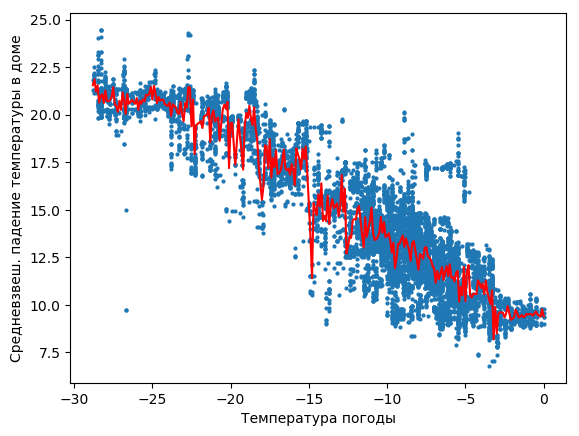

In [368]:
weather_column = "WEATHER_TEMP"
weather_rounded_column = "WEATHER_ROUNDED"
temp_delta_column = "TEMP_DELTA"
mean_group_value_column = "MEAN_GROUP_TEMP"
std_group_value_column = "STD_GROUP"
err_group_column = "ERR_COLUMN"

correlation_df = pd.DataFrame({
    weather_column: moved_weather_temp,
    temp_delta_column: temp_delta
})

correlation_df[weather_rounded_column] = correlation_df[weather_column].apply(
    lambda x: x // forward_round_step * forward_round_step
)
mean_series = correlation_df.groupby(weather_rounded_column)[temp_delta_column].mean()
correlation_df[mean_group_value_column] = correlation_df[weather_rounded_column].apply(
    lambda x: mean_series[x]
)
std_series = correlation_df.groupby(weather_rounded_column)[temp_delta_column].std()
correlation_df[std_group_value_column] = correlation_df[weather_rounded_column].apply(
    lambda x: std_series[x]
)
correlation_df[err_group_column] = correlation_df[mean_group_value_column]-correlation_df[temp_delta_column]
correlation_df[err_group_column] = correlation_df[err_group_column].abs()
err_column = correlation_df[err_group_column]

correlation_df = correlation_df.sort_values(weather_rounded_column)
correlation_df = correlation_df[correlation_df[std_group_value_column].notnull()]
weather_rouned_temp = correlation_df[weather_rounded_column].to_numpy()
mean_temp = correlation_df[mean_group_value_column]
std_temp = correlation_df[std_group_value_column]

print(f"Min/Max/Mean abs {err_column.min()}, {err_column.max()}, {err_column.mean()}")
print(f"Min/Max/Mean temp_delta {temp_delta.min()}, {temp_delta.max()}, {temp_delta.mean()}")

plt.scatter(weather_rouned_temp, correlation_df[temp_delta_column], s=4)

plt.plot(weather_rouned_temp, mean_temp, color="red")
plt.xlabel("Температура погоды")
plt.ylabel("Средневзвеш. падение температуры в доме")
plt.show()

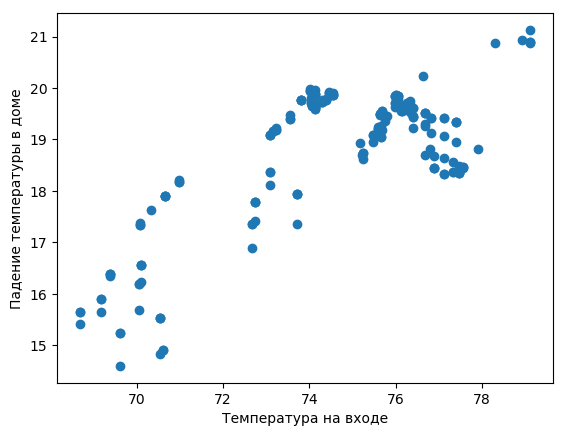

In [379]:
min_weather_temp = -20
max_weather_temp = -19

weather_column = "WEATHER_TEMP"
temp_delta_column = "TEMP_DELTA"
home_forward_column = "FORWARD_COLUMN"

correlation_df = pd.DataFrame({
    weather_column: moved_weather_temp,
    temp_delta_column: temp_delta,
    home_forward_column: moved_forward_temp
})

correlation_df = correlation_df[correlation_df[weather_column].between(min_weather_temp, max_weather_temp)]

plt.scatter(correlation_df[home_forward_column], correlation_df[temp_delta_column])
plt.xlabel("Температура на входе")
plt.ylabel("Падение температуры в доме")
plt.show()

Mean 13.102523803710938, Std 1.893981695175171


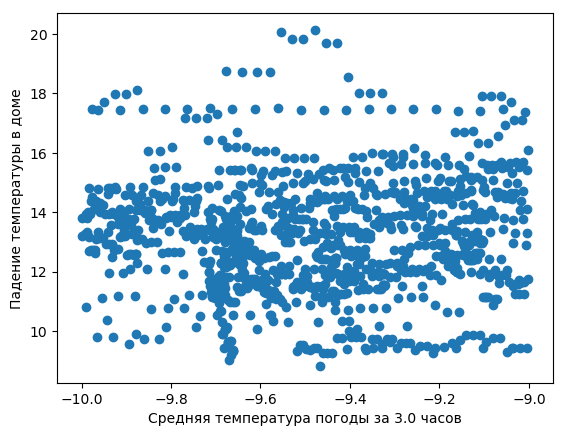

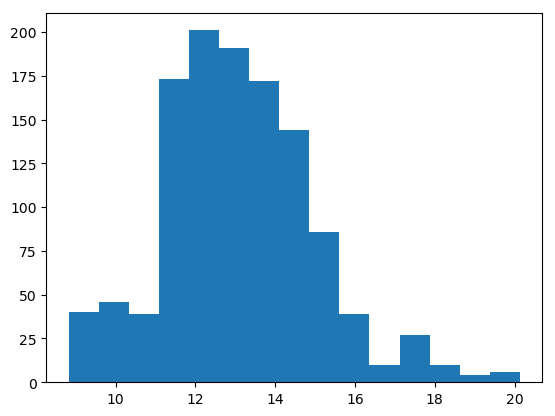

In [383]:
window_size = 60
min_mean_weather_temp = -10
max_mean_weather_temp = -9

weather_column = "WEATHER_TEMP"
temp_delta_column = "TEMP_DELTA"
home_forward_column = "HOME_FORWARD"
mean_history_weather_temp_column = "MEAN_HISTORY_WEATHER_TEMP"

history_weather_temp = []
for i in range(window_size, len(moved_weather_temp)):
    history_weather_temp.append(moved_weather_temp[i-window_size:i].mean())
mean_history_weather_temp = np.array(history_weather_temp)

correlation_df = pd.DataFrame({
    weather_column: moved_weather_temp[window_size:],
    temp_delta_column: temp_delta[window_size:],
    home_forward_column: moved_forward_temp[window_size:],
    mean_history_weather_temp_column: mean_history_weather_temp
})
correlation_df = correlation_df[correlation_df[mean_history_weather_temp_column].between(min_mean_weather_temp, max_mean_weather_temp)]

print(f"Mean {correlation_df[temp_delta_column].mean()}, Std {correlation_df[temp_delta_column].std()}")

plt.scatter(correlation_df[mean_history_weather_temp_column], correlation_df[temp_delta_column])
plt.xlabel(f"Средняя температура погоды за {window_size/20} часов")
plt.ylabel("Падение температуры в доме")
plt.show()

plt.hist(correlation_df[temp_delta_column], bins=15)
plt.show()

Mean 10.24055004119873, Std 0.1286718249320984


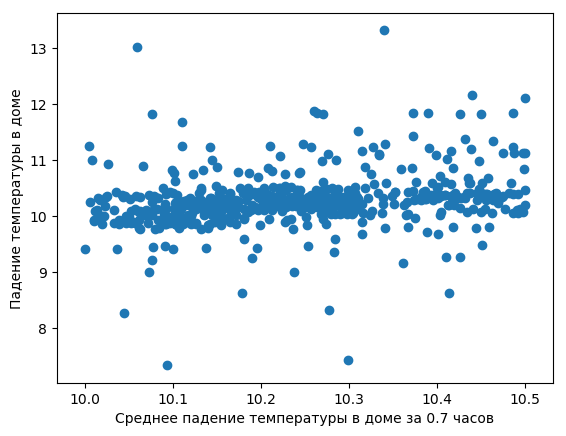

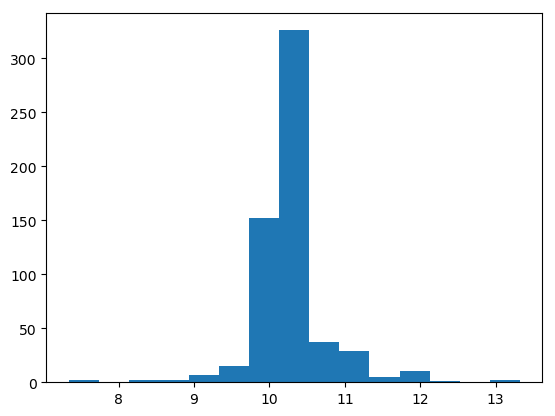

In [432]:
window_size = 14
window_size_wt_back = 20
window_size_wt_forward = 20
min_mean_history_temp_delta = 10
max_mean_history_temp_delta = 10.5

weather_column = "WEATHER_TEMP"
temp_delta_column = "TEMP_DELTA"
home_forward_column = "HOME_FORWARD"
mean_history_temp_delta_column = "MEAN_HISTORY_TEMP_DELTA"
history_td_dir_column = "HISTORY_TD_DIR"
wt_back_column = "WT_BACK"
wt_forward_column = "WT_FORWARD"

step_before = max(window_size, window_size_wt_forward)
step_after = len(temp_delta)-window_size_wt_forward

history_td_dir = []
mean_history_temp_delta = []
wt_back = []
wt_forward = []
wt_current = []

for i in range(step_before, step_after):
    mean_history_temp_delta.append(temp_delta[i-window_size:i].mean())
    history_td_dir.append((moved_weather_temp[i-window_size]-moved_weather_temp[i])/window_size)
    wt_back.append(moved_weather_temp[i-window_size_wt_back])
    wt_forward.append(moved_weather_temp[i+window_size_wt_forward])
    
mean_history_temp_delta = np.array(mean_history_temp_delta)
history_td_dir = np.array(history_td_dir)
wt_back = np.array(wt_back)
wt_forward = np.array(wt_forward)

correlation_df = pd.DataFrame({
    weather_column: moved_weather_temp[step_before:step_after],
    temp_delta_column: temp_delta[step_before:step_after],
    home_forward_column: moved_forward_temp[step_before:step_after],
    mean_history_temp_delta_column: mean_history_temp_delta,
    history_td_dir_column: history_td_dir,
    wt_back_column: wt_back,
    wt_forward_column: wt_forward
})
#correlation_df = correlation_df[correlation_df[history_td_dir_column]<0]
correlation_df2 = correlation_df[correlation_df[mean_history_temp_delta_column].between(min_mean_history_temp_delta, max_mean_history_temp_delta)]
print(f"Mean {correlation_df2[mean_history_temp_delta_column].mean()}, Std {correlation_df2[mean_history_temp_delta_column].std()}")

plt.scatter(correlation_df2[mean_history_temp_delta_column], correlation_df2[temp_delta_column])
plt.xlabel(f"Среднее падение температуры в доме за {window_size/20} часов")
plt.ylabel("Падение температуры в доме")
plt.show()

plt.hist(correlation_df2[temp_delta_column], bins=15)
plt.show()